In [1]:
import sys
sys.path.append('../src')
import matplotlib.pyplot as plt

In [2]:
import os
os.environ['TIKTOKEN_CACHE_DIR'] = ""

In [3]:
from utils import get_combined_df, tokenize, reverse_tokenize
from bm25 import search, mean_reciprocal_rank, precision_at_k, average_precision_score
# from pyserini.index.lucene import IndexReader
from pyserini.search.lucene import LuceneSearcher
import json

/home/ssg2/miniconda3/envs/ds/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the combined dataframe for a repository
repo_dir = "../smalldata/fbr"
idx_path = "../smalldata/fbr/index_commit_tokenized"

In [4]:
df = get_combined_df(repo_dir)

# EDA


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69835 entries, 0 to 69834
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   owner                  69835 non-null  string  
 1   repo_name              69835 non-null  string  
 2   commit_date            69835 non-null  int64   
 3   commit_id              69835 non-null  string  
 4   commit_message         69835 non-null  string  
 5   file_path              69835 non-null  string  
 6   cur_file_content       67179 non-null  string  
 7   previous_commit_id     64247 non-null  string  
 8   previous_file_path     4140 non-null   string  
 9   previous_file_content  64247 non-null  string  
 10  diff                   61590 non-null  string  
 11  status                 69835 non-null  category
 12  is_merge_request       69835 non-null  bool    
 13  file_extension         69835 non-null  object  
dtypes: bool(1), category(1), int64(1), obj

In [52]:
file_edit_count = df.groupby('file_path').size().reset_index(name='edit_count')

In [53]:
file_edit_count = file_edit_count.sort_values(by='edit_count', ascending=False)

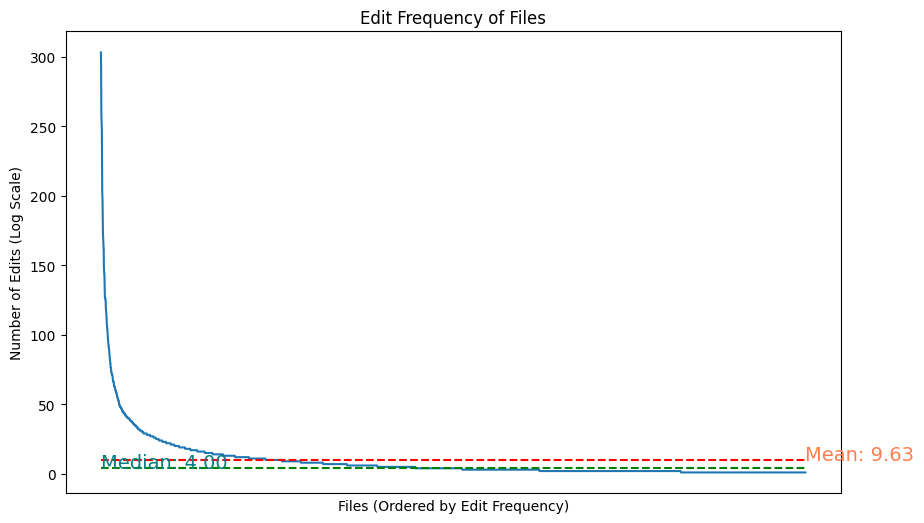

In [72]:
# 3. Plot the edit frequency curve
plt.figure(figsize=(10,6))
plt.plot(file_edit_count['edit_count'].values)
# plt.yscale('log')  # log scale can give a better visualization for such data
# plot the mean edit frequency
mean_edit_frequency = file_edit_count['edit_count'].mean()
plt.plot([0, len(file_edit_count)], [mean_edit_frequency, mean_edit_frequency], 'r--')
# plot the median edit frequency
median_edit_frequency = file_edit_count['edit_count'].median()
plt.plot([0, len(file_edit_count)], [median_edit_frequency, median_edit_frequency], 'g--')

# label the mean and median with values with mean on the right and median on the left
plt.text(len(file_edit_count), mean_edit_frequency, 'Mean: {:.2f}'.format(mean_edit_frequency), fontsize=14, color='coral')
plt.text(0, median_edit_frequency, 'Median: {:.2f}'.format(median_edit_frequency), fontsize=14, color='teal')



plt.title('Edit Frequency of Files')
plt.xlabel('Files (Ordered by Edit Frequency)')
plt.ylabel('Number of Edits (Log Scale)')
plt.xticks([])  # No labels on x-axis as per your request
plt.show()

In [57]:
file_edit_count.head(10)

,file_path,edit_count
3651,packages/react-reconciler/src/ReactFiberWorkLo...,303
4697,packages/shared/forks/ReactFeatureFlags.www.js,301
4609,packages/shared/ReactFeatureFlags.js,294
3652,packages/react-reconciler/src/ReactFiberWorkLo...,277
5627,src/core/ReactCompositeComponent.js,275
5152,scripts/rollup/bundles.js,258
4684,packages/shared/forks/ReactFeatureFlags.native...,256
4692,packages/shared/forks/ReactFeatureFlags.test-r...,252
3507,packages/react-reconciler/src/ReactFiberBeginW...,252
4690,packages/shared/forks/ReactFeatureFlags.test-r...,250


In [81]:
# percentage of files that have been edited more than 10 times
print(f'Percentage of files that have been edited more than 10 times: {len(file_edit_count[file_edit_count["edit_count"] > 10]) / len(file_edit_count) * 100:.2f}%')

# percentage of files that have been edited more than mean times
print(f'Percentage of files that have been edited more than mean times ({mean_edit_frequency:.2f}): {len(file_edit_count[file_edit_count["edit_count"] > mean_edit_frequency]) / len(file_edit_count) * 100:.2f}%')

# percentage of files that have been edited more than median times
print(f'Percentage of files that have been edited more than median times ({median_edit_frequency:.2f}): {len(file_edit_count[file_edit_count["edit_count"] > median_edit_frequency]) / len(file_edit_count) * 100:.2f}%')

Percentage of files that have been edited more than 10 times: 23.35%
Percentage of files that have been edited more than mean times (9.63): 25.70%
Percentage of files that have been edited more than median times (4.00): 44.64%


In [4]:
# # make all this into a function which just takes in a df and plots the graph and returns the file_edit_count df

# def plot_edit_frequency(repo, plot=False):
#     df = get_combined_df(f'../2_8/{repo}')
#     file_edit_count = df.groupby('file_path').size().reset_index(name='edit_count')
#     file_edit_count = file_edit_count.sort_values(by='edit_count', ascending=False)
#     # get total number of edits
#     total_edits = file_edit_count['edit_count'].sum()
#     print(f'Total number of edits: {total_edits}')
#     # get percentage of total edits as a column
#     file_edit_count['edit_percentage'] = file_edit_count['edit_count'] / total_edits * 100


#     mean_edit_frequency = file_edit_count['edit_count'].mean()
#     median_edit_frequency = file_edit_count['edit_count'].median()

#     if plot:
#         # 3. Plot the edit frequency curve
#         plt.figure(figsize=(10,6))
#         plt.plot(file_edit_count['edit_count'].values)
#         # plt.yscale('log')  # log scale can give a better visualization for such data
#         # plot the mean edit frequency
#         plt.plot([0, len(file_edit_count)], [mean_edit_frequency, mean_edit_frequency], 'r--')
#         # plot the median edit frequency
#         plt.plot([0, len(file_edit_count)], [median_edit_frequency, median_edit_frequency], 'g--')

#         # label the mean and median with values with mean on the right and median on the left
#         plt.text(len(file_edit_count), mean_edit_frequency, 'Mean: {:.2f}'.format(mean_edit_frequency), fontsize=14, color='coral')
#         # plt.text(0, median_edit_frequency, 'Median: {:.2f}'.format(median_edit_frequency), fontsize=14, color='teal')
#         # median text at 45 degrees
#         plt.text(0, median_edit_frequency, 'Median: {:.2f}'.format(median_edit_frequency), fontsize=14, color='teal', rotation=45)



#         plt.title(f'Edit Frequency of Files {repo}')
#         plt.xlabel('Files (Ordered by Edit Frequency)')
#         plt.ylabel('Number of Edits')
#         plt.xticks([])  # No labels on x-axis as per your request
#         plt.show()

#     # file_edit_count.head(10)

#     # percentage of files that have been edited more than 10 times
#     print(f'Percentage of files that have been edited more than 10 times: {len(file_edit_count[file_edit_count["edit_count"] > 10]) / len(file_edit_count) * 100:.2f}%')

#     # percentage of files that have been edited more than mean times
#     print(f'Percentage of files that have been edited more than mean times ({mean_edit_frequency:.2f}): {len(file_edit_count[file_edit_count["edit_count"] > mean_edit_frequency]) / len(file_edit_count) * 100:.2f}%')

#     # percentage of files that have been edited more than median times
#     print(f'Percentage of files that have been edited more than median times ({median_edit_frequency:.2f}): {len(file_edit_count[file_edit_count["edit_count"] > median_edit_frequency]) / len(file_edit_count) * 100:.2f}%')

#     return file_edit_count

In [4]:
def plot_edit_frequency(repo, plot=False):
    # Assuming df is the dataframe passed to the function
    # Calculate the total number of unique commits
    df = get_combined_df(f'../2_8/{repo}')
    total_unique_commits = df['commit_id'].nunique()

    file_edit_count = df.groupby('file_path').size().reset_index(name='edit_count')
    file_edit_count = file_edit_count.sort_values(by='edit_count', ascending=False)

    # get percentage of edits relative to total number of unique commits
    file_edit_count['edit_percentage'] = file_edit_count['edit_count'] / total_unique_commits * 100

    mean_edit_frequency = file_edit_count['edit_count'].mean()
    median_edit_frequency = file_edit_count['edit_count'].median()

    if plot:
        # Plot the edit frequency curve
        plt.figure(figsize=(10,6))
        plt.plot(file_edit_count['edit_count'].values)
        # plot the mean edit frequency
        plt.plot([0, len(file_edit_count)], [mean_edit_frequency, mean_edit_frequency], 'r--')
        # plot the median edit frequency
        plt.plot([0, len(file_edit_count)], [median_edit_frequency, median_edit_frequency], 'g--')

        plt.text(len(file_edit_count), mean_edit_frequency, 'Mean: {:.2f}'.format(mean_edit_frequency), fontsize=14, color='coral')
        plt.text(0, median_edit_frequency, 'Median: {:.2f}'.format(median_edit_frequency), fontsize=14, color='teal', rotation=45)

        plt.title(f'Edit Frequency of Files Across {total_unique_commits} Commits in {repo}')
        plt.xlabel('Files (Ordered by Edit Frequency)')
        plt.ylabel('Number of Edits')
        plt.xticks([])  # No labels on x-axis
        plt.show()
    print(f'Total number of unique commits: {total_unique_commits}')
    # Print statements to show percentages related to mean and median
    print(f'Percentage of files that have been edited more than 10 times: {len(file_edit_count[file_edit_count["edit_count"] > 10]) / len(file_edit_count) * 100:.2f}%')
    print(f'Percentage of files that have been edited more than mean times ({mean_edit_frequency:.2f}): {len(file_edit_count[file_edit_count["edit_count"] > mean_edit_frequency]) / len(file_edit_count) * 100:.2f}%')
    print(f'Percentage of files that have been edited more than median times ({median_edit_frequency:.2f}): {len(file_edit_count[file_edit_count["edit_count"] > median_edit_frequency]) / len(file_edit_count) * 100:.2f}%')

    return file_edit_count

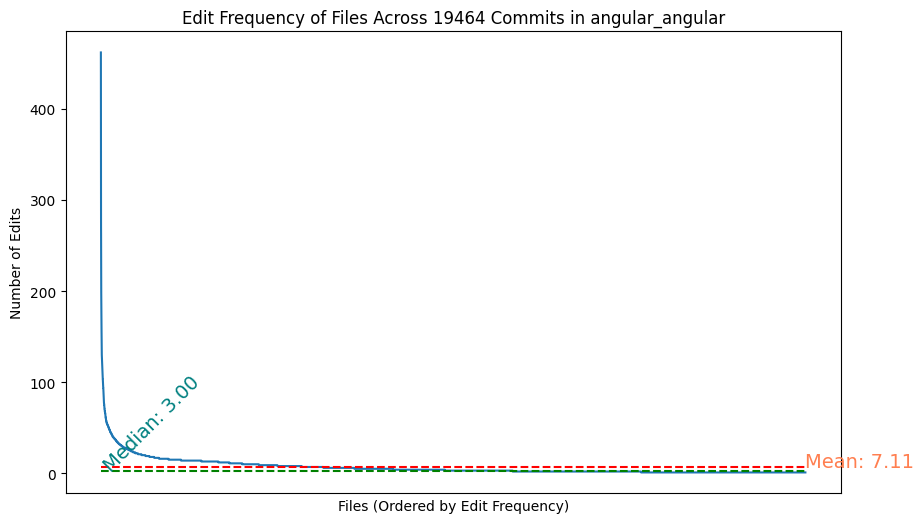

Total number of unique commits: 19464
Percentage of files that have been edited more than 10 times: 20.06%
Percentage of files that have been edited more than mean times (7.11): 28.50%
Percentage of files that have been edited more than median times (3.00): 48.82%


,file_path,edit_count,edit_percentage
5365,gulpfile.js,462,2.373613
17918,packages/core/src/render3/instructions.ts,364,1.870119
17033,packages/compiler-cli/test/ngtsc/ngtsc_spec.ts,347,1.782778
17205,packages/compiler/src/render3/view/template.ts,280,1.438553
17953,packages/core/src/render3/instructions/shared.ts,273,1.402589
...,...,...,...
5939,modules/@angular/animation/src/dsl/animation_t...,1,0.005138
5941,modules/@angular/animation/src/dsl/animation_v...,1,0.005138
5942,modules/@angular/animation/src/dsl/style_norma...,1,0.005138
5943,modules/@angular/animation/src/dsl/style_norma...,1,0.005138


In [5]:
plot_edit_frequency('angular_angular', plot=True)

In [7]:
REPO_LIST = ['angular_angular', 'pytorch_pytorch', 'vercel_hyper', 'django_django', 'elastic_elasticsearch', 'git_git', 'vercel_next.js']

Plotting angular_angular


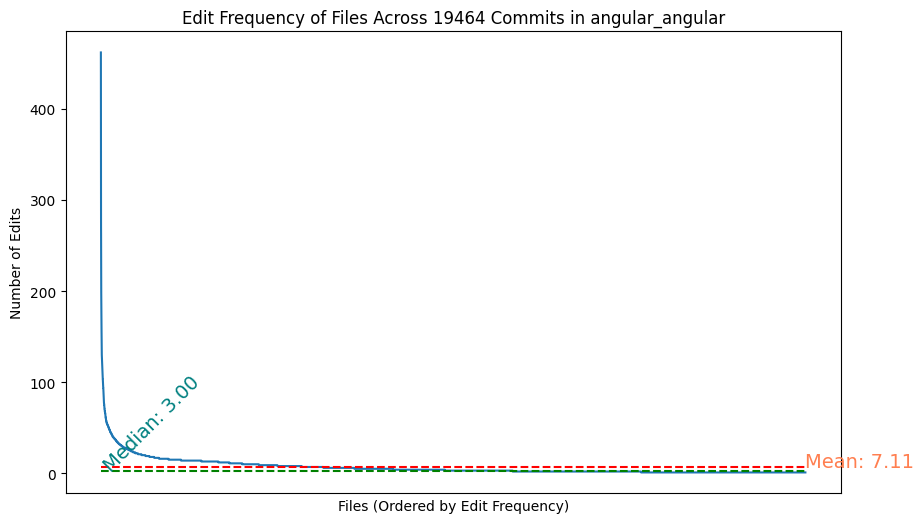

Total number of unique commits: 19464
Percentage of files that have been edited more than 10 times: 20.06%
Percentage of files that have been edited more than mean times (7.11): 28.50%
Percentage of files that have been edited more than median times (3.00): 48.82%
                                              file_path  edit_count  \
5365                                        gulpfile.js         462   
17918         packages/core/src/render3/instructions.ts         364   
17033    packages/compiler-cli/test/ngtsc/ngtsc_spec.ts         347   
17205    packages/compiler/src/render3/view/template.ts         280   
17953  packages/core/src/render3/instructions/shared.ts         273   

       edit_percentage  
5365          2.373613  
17918         1.870119  
17033         1.782778  
17205         1.438553  
17953         1.402589  
Plotting pytorch_pytorch


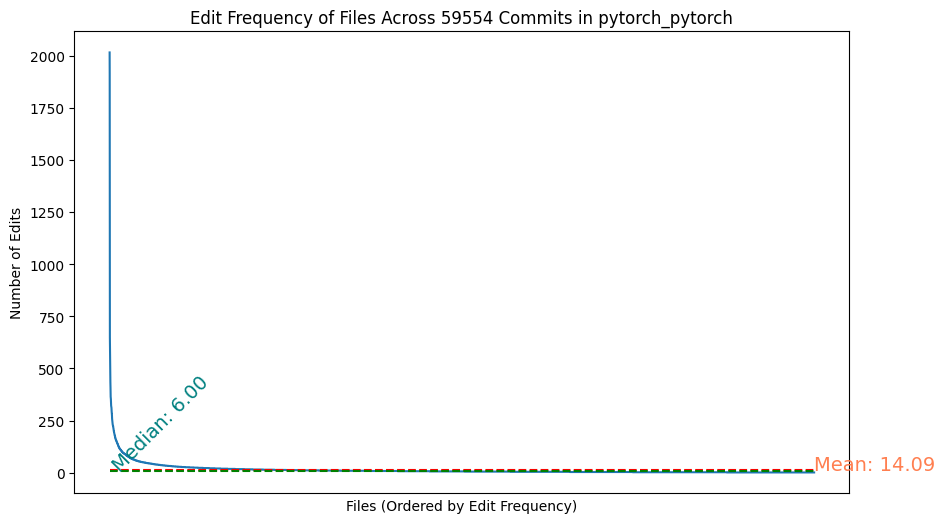

Total number of unique commits: 59554
Percentage of files that have been edited more than 10 times: 29.64%
Percentage of files that have been edited more than mean times (14.09): 21.74%
Percentage of files that have been edited more than median times (6.00): 45.42%
                                               file_path  edit_count  \
11890                                 test/test_torch.py        2015   
19270  torch/testing/_internal/common_methods_invocat...        1977   
11775                                   test/test_jit.py        1914   
11824                                    test/test_nn.py        1423   
11704                              test/test_autograd.py        1022   

       edit_percentage  
11890         3.383484  
19270         3.319676  
11775         3.213890  
11824         2.389428  
11704         1.716090  
Plotting vercel_hyper


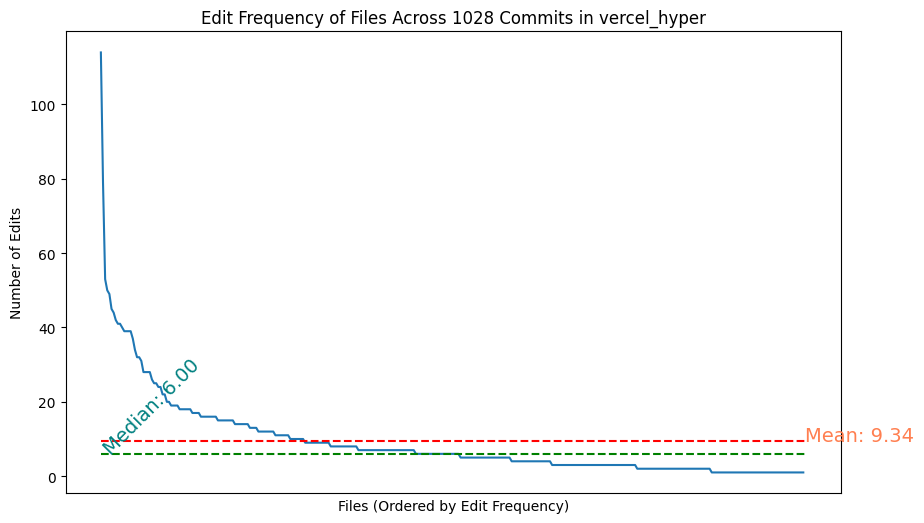

Total number of unique commits: 1028
Percentage of files that have been edited more than 10 times: 26.89%
Percentage of files that have been edited more than mean times (9.34): 29.00%
Percentage of files that have been edited more than median times (6.00): 44.71%
                  file_path  edit_count  edit_percentage
206  lib/components/term.js         114        11.089494
28             app/index.js          79         7.684825
95           app/plugins.js          53         5.155642
237            lib/hterm.js          50         4.863813
164                index.js          49         4.766537
Plotting django_django


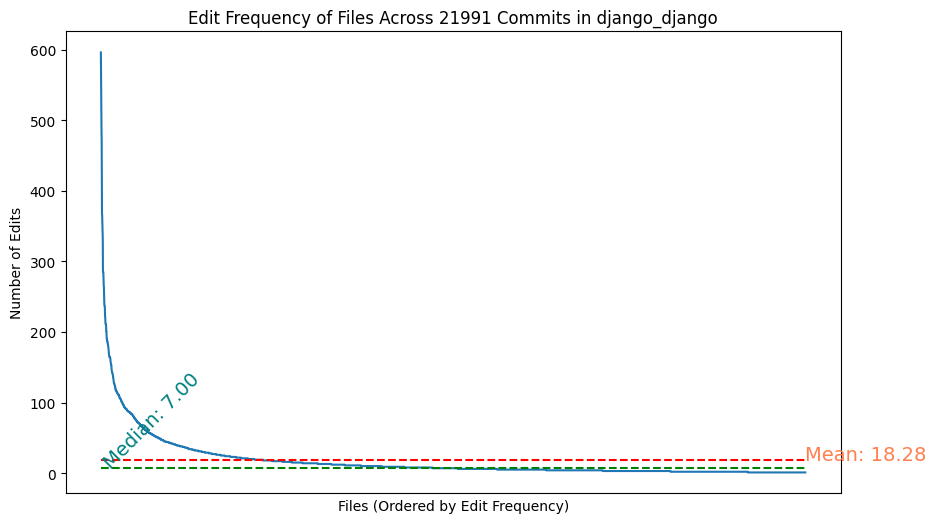

Total number of unique commits: 21991
Percentage of files that have been edited more than 10 times: 36.92%
Percentage of files that have been edited more than mean times (18.28): 23.01%
Percentage of files that have been edited more than median times (7.00): 47.06%
                                file_path  edit_count  edit_percentage
1371            django/db/models/query.py         596         2.710200
1381        django/db/models/sql/query.py         564         2.564686
1344  django/db/models/fields/__init__.py         524         2.382793
197       django/contrib/admin/options.py         485         2.205448
1338             django/db/models/base.py         484         2.200900
Plotting elastic_elasticsearch


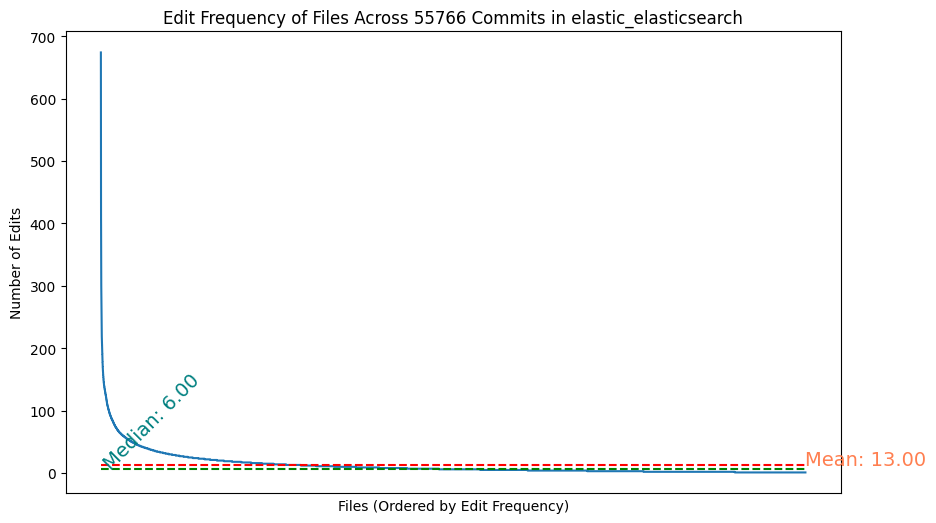

Total number of unique commits: 55766
Percentage of files that have been edited more than 10 times: 33.11%
Percentage of files that have been edited more than mean times (13.00): 26.27%
Percentage of files that have been edited more than median times (6.00): 47.97%
                                               file_path  edit_count  \
5766   core/src/main/java/org/elasticsearch/index/sha...         674   
53263  test/framework/src/main/java/org/elasticsearch...         624   
53277  test/framework/src/main/java/org/elasticsearch...         609   
668    buildSrc/src/main/groovy/org/elasticsearch/gra...         599   
53265  test/framework/src/main/java/org/elasticsearch...         587   

       edit_percentage  
5766          1.208622  
53263         1.118961  
53277         1.092063  
668           1.074131  
53265         1.052613  
Plotting git_git


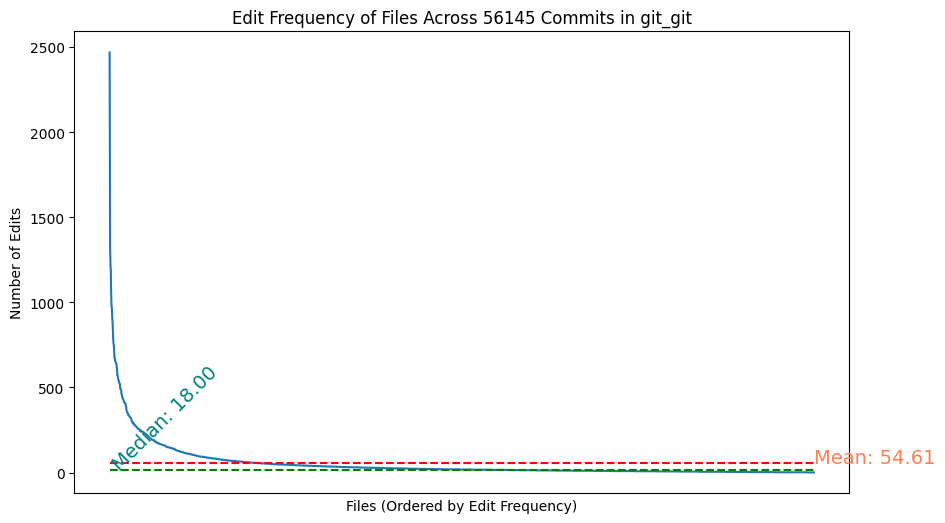

Total number of unique commits: 56145
Percentage of files that have been edited more than 10 times: 68.71%
Percentage of files that have been edited more than mean times (54.61): 21.55%
Percentage of files that have been edited more than median times (18.00): 49.68%
        file_path  edit_count  edit_percentage
308       cache.h        2468         4.395761
666        diff.c        1818         3.238044
1217       refs.c        1323         2.356399
1305   revision.c        1257         2.238846
1333  sha1_file.c        1202         2.140885
Plotting vercel_next.js


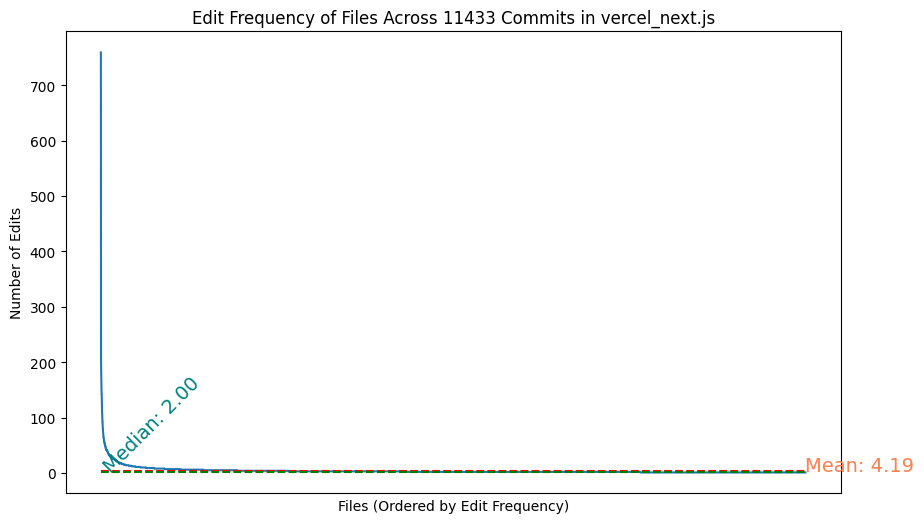

Total number of unique commits: 11433
Percentage of files that have been edited more than 10 times: 5.58%
Percentage of files that have been edited more than mean times (4.19): 19.35%
Percentage of files that have been edited more than median times (2.00): 42.90%
                                             file_path  edit_count  \
8450             packages/next/build/webpack-config.ts         759   
8008                      packages/next/build/index.ts         477   
11920                        packages/next/taskfile.js         333   
9691   packages/next/next-server/server/next-server.ts         230   
18779   test/integration/production/test/index.test.js         205   

       edit_percentage  
8450          6.638678  
8008          4.172133  
11920         2.912621  
9691          2.011720  
18779         1.793055  


In [8]:
for repo in REPO_LIST:
    print(f'Plotting {repo}')
    res = plot_edit_frequency(repo, plot=True)
    print(res.head(5))

Plotting angular_angular
Total number of edits: 151904


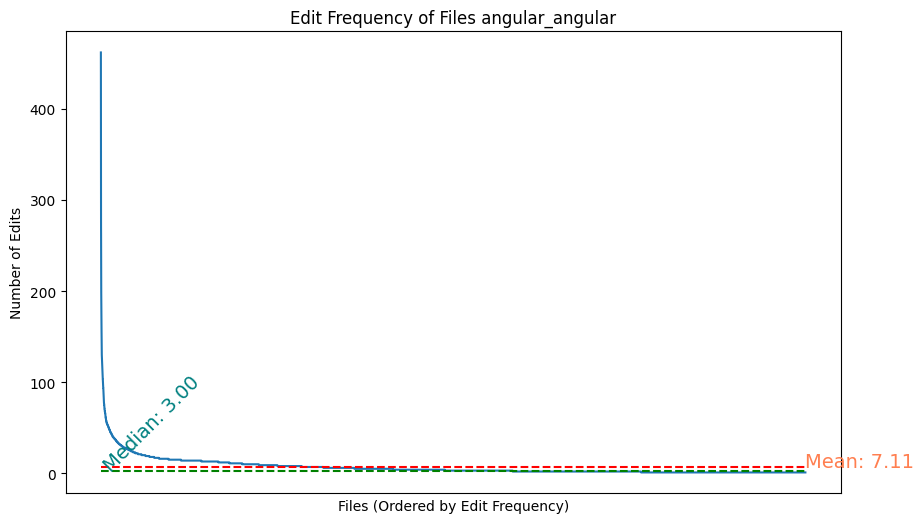

Percentage of files that have been edited more than 10 times: 20.06%
Percentage of files that have been edited more than mean times (7.11): 28.50%
Percentage of files that have been edited more than median times (3.00): 48.82%
                                              file_path  edit_count  \
5365                                        gulpfile.js         462   
17918         packages/core/src/render3/instructions.ts         364   
17033    packages/compiler-cli/test/ngtsc/ngtsc_spec.ts         347   
17205    packages/compiler/src/render3/view/template.ts         280   
17953  packages/core/src/render3/instructions/shared.ts         273   

       edit_percentage  
5365          0.304139  
17918         0.239625  
17033         0.228434  
17205         0.184327  
17953         0.179719  
Plotting pytorch_pytorch
Total number of edits: 276846


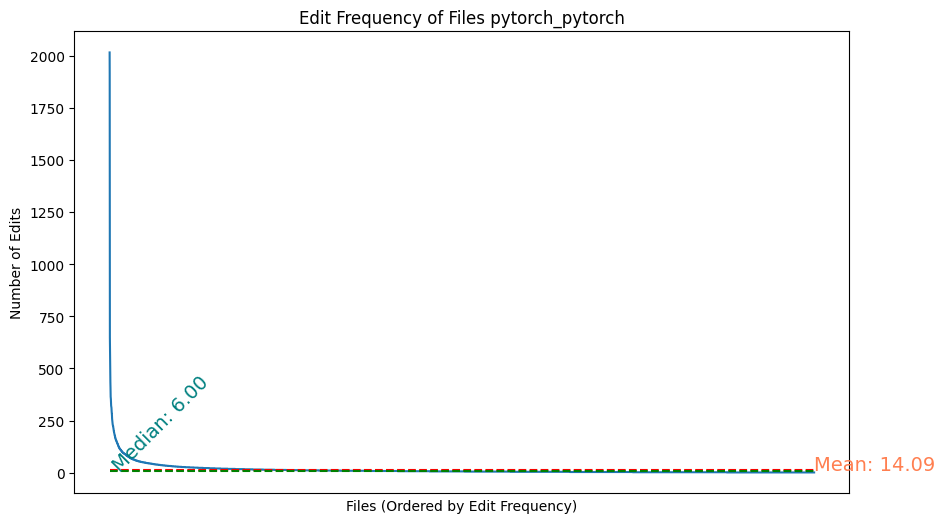

Percentage of files that have been edited more than 10 times: 29.64%
Percentage of files that have been edited more than mean times (14.09): 21.74%
Percentage of files that have been edited more than median times (6.00): 45.42%
                                               file_path  edit_count  \
11890                                 test/test_torch.py        2015   
19270  torch/testing/_internal/common_methods_invocat...        1977   
11775                                   test/test_jit.py        1914   
11824                                    test/test_nn.py        1423   
11704                              test/test_autograd.py        1022   

       edit_percentage  
11890         0.727841  
19270         0.714115  
11775         0.691359  
11824         0.514004  
11704         0.369158  
Plotting vercel_hyper
Total number of edits: 3090


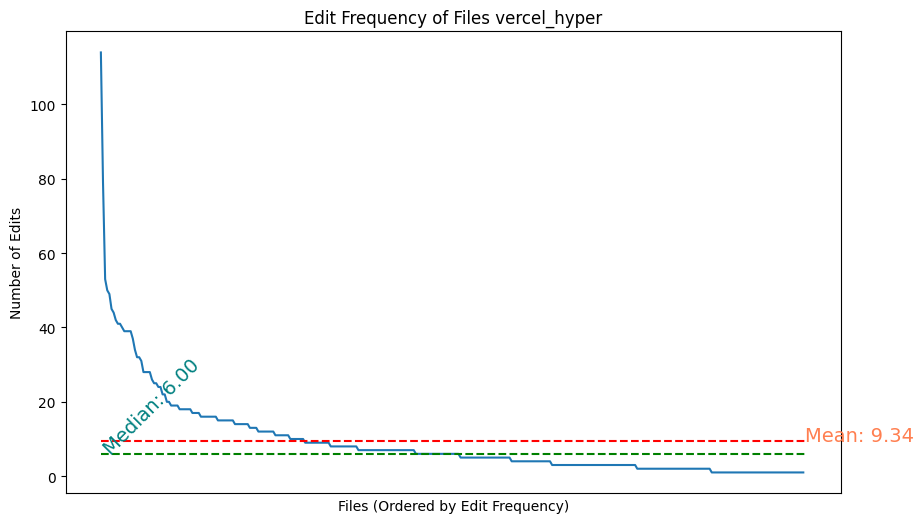

Percentage of files that have been edited more than 10 times: 26.89%
Percentage of files that have been edited more than mean times (9.34): 29.00%
Percentage of files that have been edited more than median times (6.00): 44.71%
                  file_path  edit_count  edit_percentage
206  lib/components/term.js         114         3.689320
28             app/index.js          79         2.556634
95           app/plugins.js          53         1.715210
237            lib/hterm.js          50         1.618123
164                index.js          49         1.585761
Plotting golang_go
Total number of edits: 286618


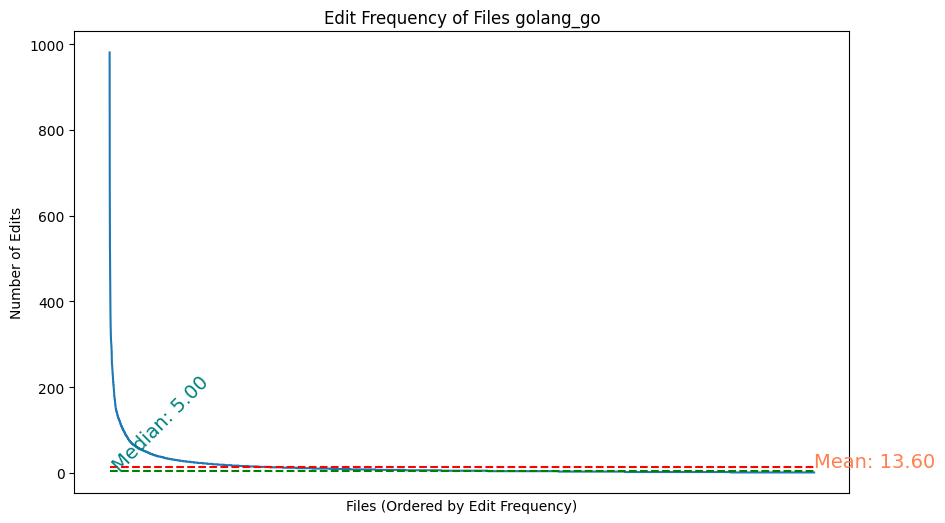

Percentage of files that have been edited more than 10 times: 28.78%
Percentage of files that have been edited more than mean times (13.60): 22.70%
Percentage of files that have been edited more than median times (5.00): 47.06%
                                   file_path  edit_count  edit_percentage
2174      src/cmd/compile/internal/gc/ssa.go         981         0.342267
15120                    src/runtime/proc.go         734         0.256090
3504                   src/cmd/go/go_test.go         680         0.237250
4896         src/cmd/link/internal/ld/lib.go         675         0.235505
2578   src/cmd/compile/internal/ssa/opGen.go         670         0.233761


In [ ]:
for repo in REPO_LIST:
    print(f'Plotting {repo}')
    res = plot_edit_frequency(repo, plot=True)
    print(res.head(5))

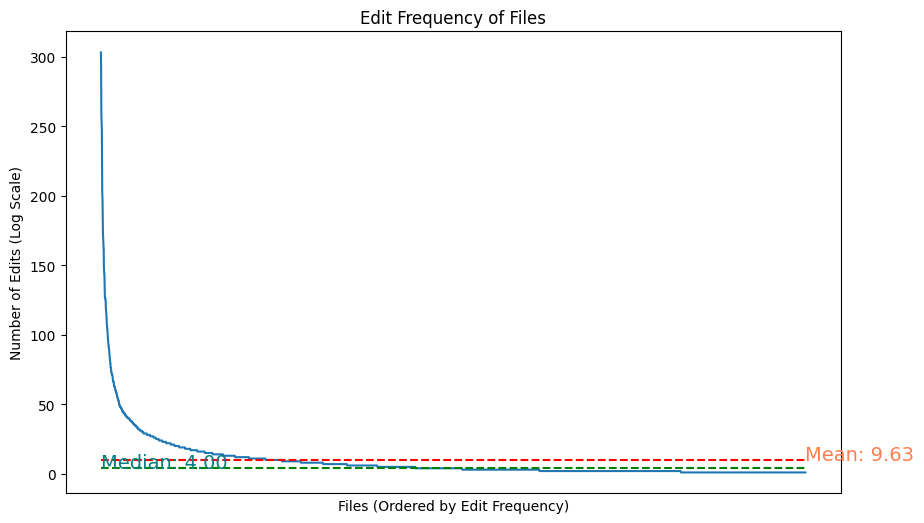

Percentage of files that have been edited more than 10 times: 23.35%
Percentage of files that have been edited more than mean times (9.63): 25.70%
Percentage of files that have been edited more than median times (4.00): 44.64%


In [83]:
fbr_file_edit_count = plot_edit_frequency(df, plot=True)

In [11]:
def average_files_changed_per_commit(repo):
    df = get_combined_df(f'../2_8/{repo}')
    # Group by 'commit_id' and count unique 'file_path' for each group
    commit_file_changes = df.groupby('commit_id')['file_path'].nunique().reset_index(name='num_files')

    # Calculate the sum of 'num_files' for all commits
    total_files_changed = commit_file_changes['num_files'].sum()

    # Calculate the total number of unique commits
    total_unique_commits = commit_file_changes['commit_id'].nunique()

    # Calculate the average number of files changed per commit
    average_files_per_commit = total_files_changed / total_unique_commits

    return average_files_per_commit

In [12]:
for repo in REPO_LIST:
    print(f'Average number of files changed per commit for {repo}: {average_files_changed_per_commit(repo):.2f}')

Average number of files changed per commit for angular_angular: 7.80
Average number of files changed per commit for pytorch_pytorch: 4.65
Average number of files changed per commit for vercel_hyper: 3.01
Average number of files changed per commit for django_django: 3.69
Average number of files changed per commit for elastic_elasticsearch: 15.99
Average number of files changed per commit for git_git: 2.92
Average number of files changed per commit for vercel_next.js: 7.48


# BM25

In [5]:
def sample_query(df, seed=42):
    """
    Sample a query from the dataframe
    """
    sampled_commit = df.drop_duplicates(subset='commit_id').sample(1, random_state=seed).iloc[0]
    return {
        'commit_message': sampled_commit['commit_message'],
        'commit_id': sampled_commit['commit_id'],
        'commit_date': sampled_commit['commit_date'],
        'actual_files_modified': df[df['commit_id'] == sampled_commit['commit_id']]['file_path'].tolist()
    }

In [6]:
def print_search_results(query, results, showOnlyActualModified = False):
    """
    Print the search results
    """
    actual_modified_files = query['actual_files_modified']
    for i in range(len(results)):
    # print(f'{i+1:2} {hits[i].docid:4} {hits[i].score:.5f}')
    # print with repo name and file name
        obj = json.loads(results[i].raw)
        commit_date = int(obj["commit_date"])
        if showOnlyActualModified:
            if obj["file_path"] in actual_modified_files:
                print(f'{i+1:2} {obj["file_path"]:4} {results[i].score:.5f} {commit_date}')
        else:
            print(f'{i+1:2} {obj["file_path"]:4} {results[i].score:.5f} {commit_date}')


In [7]:
def evaluate(hits, actual_modified_files, k=1000):
    retrieved_files = [json.loads(hit.raw)['file_path'] for hit in hits]
    relevant = [1 if file in actual_modified_files else 0 for file in retrieved_files]

    metrics = {
        'MAP': average_precision_score(relevant, [1]*len(relevant)) if any(relevant) else 0,
        'P@10': precision_at_k(relevant, 10),
        'P@100': precision_at_k(relevant, 100),
        'P@1000': precision_at_k(relevant, 1000),
        'MRR': mean_reciprocal_rank(relevant),
        f'Recall@{k}': len(set(file for idx, file in enumerate(retrieved_files) if relevant[idx] == 1)) / len(actual_modified_files)
    }

    return {k: round(v, 4) for k, v in metrics.items()}

In [8]:
# Sample a random query from the dataframe
query = sample_query(df, seed=108)
# Print the sample query's details
query

{'commit_message': 'fix typo on inline comment (#13364)\n\n',
 'commit_id': 'e07a3cd28f3b360755d6832a01d724a3b7576bc4',
 'commit_date': 1533916266,
 'actual_files_modified': ['packages/react-reconciler/src/ReactFiberScheduler.js']}

In [9]:
searcher = LuceneSearcher(idx_path)

In [10]:
search_results = search(searcher, query['commit_message'], query['commit_date'], 1000)

In [11]:
print_search_results(query, search_results , showOnlyActualModified=True)

174 packages/react-reconciler/src/ReactFiberScheduler.js 9.77590 1533746573


In [12]:
evaluate(search_results, query['actual_files_modified'])

{'MAP': 0.0014,
 'P@10': 0.0,
 'P@100': 0.0,
 'P@1000': 0.001,
 'MRR': 0.0057,
 'Recall@1000': 1.0}

# Reranking

In [20]:
from transformers import BertTokenizer, BertForSequenceClassification, RobertaTokenizer, RobertaConfig, RobertaModel
import torch

## bert-base-uncased

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # 2 labels: Relevant or Not relevant

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
def get_bert_input(query_message, commit_message):
    """
    Convert the query and commit message into BERT input format.
    """
    return tokenizer(query_message + " [SEP] " + commit_message, return_tensors="pt", truncation=True, padding=True, max_length=512)

In [16]:
def get_relevance_score(input_data):
    """
    Use BERT to predict the relevance score.
    """
    with torch.no_grad():
        logits = model(**input_data).logits[0]
    return logits[1] - logits[0]  # Difference between scores for "relevant" and "not relevant"

In [17]:
def rerank_with_bert(query_message, search_results):
    """
    Rerank the BM25 search results using BERT.
    """
    scores = []
    for hit in search_results:
        # commit_message = json.loads(hit.raw)["commit_message"]
        commit_message =reverse_tokenize(json.loads(hit.raw)['contents'])
        bert_input = get_bert_input(query_message, commit_message)
        relevance_score = get_relevance_score(bert_input)
        scores.append(relevance_score)

    reranked_results = [hit for _, hit in sorted(zip(scores, search_results), key=lambda pair: pair[0], reverse=True)]

    return reranked_results

In [18]:
# Use BERT to rerank the BM25 search results
reranked_results = rerank_with_bert(query['commit_message'], search_results)

# Print the reranked results
print("Reranked results:")
print_search_results(query, reranked_results)

Reranked results:
 1 packages/react-dom/node-stream.js 7.26790 1498368702
 2 scripts/rollup/bundles.js 7.26790 1498368702
 3 src/node_modules/react-dom/node-stream.js 7.26790 1498368702
 4 src/node_modules/react-dom/server.js 7.26790 1498368702
 5 src/renderers/dom/ReactDOMNodeStreamEntry.js 7.26790 1498368702
 6 src/renderers/dom/ReactDOMNodeStreamRenderer.js 7.26790 1498368702
 7 src/renderers/dom/ReactDOMServerEntry.js 7.26789 1498368702
 8 src/renderers/dom/ReactDOMStringRenderer.js 7.26789 1498368702
 9 src/renderers/dom/shared/__tests__/ReactDOMServerIntegration-test.js 7.26789 1498368702
10 src/renderers/shared/server/ReactPartialRenderer.js 7.26789 1498368702
11 src/isomorphic/children/flattenChildren.js 8.20580 1499899781
12 src/renderers/__tests__/ReactChildReconciler-test.js 8.20580 1499899781
13 src/renderers/__tests__/ReactMultiChild-test.js 8.20580 1499899781
14 src/renderers/shared/fiber/ReactChildFiber.js 8.20580 1499899781
15 src/renderers/shared/stack/reconciler/React

In [19]:
print_search_results(query, reranked_results, showOnlyActualModified=True)

672 packages/react-reconciler/src/ReactFiberScheduler.js 9.77590 1533746573


In [22]:
evaluate(reranked_results, query['actual_files_modified'])

{'MAP': 0.0014,
 'P@10': 0.0,
 'P@100': 0.0,
 'P@1000': 0.001,
 'MRR': 0.0015,
 'Recall@1000': 1.0}

## codebert-base

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.to(device)
model.eval()

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(50265, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropou

In [31]:
def get_codebert_embedding(text1, text2):
    """
    Get the embeddings from CodeBERT for a given pair of text
    """
    tokens1 = tokenizer.tokenize(text1)
    tokens2 = tokenizer.tokenize(text2)

    # Ensure the combined length doesn't exceed the model's max input length (512 tokens)
    max_tokens_for_text2 = 512 - len(tokens1) - 3  # -3 for [CLS], [SEP], and [EOS] tokens
    if len(tokens2) > max_tokens_for_text2:
        tokens2 = tokens2[:max_tokens_for_text2]

    tokens = [tokenizer.cls_token] + tokens1 + [tokenizer.sep_token] + tokens2 + [tokenizer.eos_token]
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    with torch.no_grad():
        context_embeddings = model(torch.tensor(token_ids).unsqueeze(0).to(device))[0]
    # Return only the embedding for the [CLS] token
    return context_embeddings[0, 0].unsqueeze(0)

In [27]:
def rerank_results(search_results, query_text):
    """
    Rerank the search results using CodeBERT
    """
    reranked_results = []
    query_embedding = get_codebert_embedding(query_text, "")  # We're getting the embedding for just the query here

    for result in search_results:
        result_obj = json.loads(result.raw)
        cur_commit_message = reverse_tokenize(result_obj["contents"])
        result_embedding = get_codebert_embedding("", cur_commit_message)  # Getting embedding for each result
        score = torch.nn.functional.cosine_similarity(query_embedding, result_embedding, dim=-1)
        reranked_results.append((result, score.item()))

    # Sort by CodeBERT similarity score (from high to low)
    reranked_results.sort(key=lambda x: x[1], reverse=True)
    return [result[0] for result in reranked_results]  # Return results only (without scores)

In [32]:
codebert_reranked_results = rerank_results(search_results, query['commit_message'])

print("CodeBERT reranked results:")
print_search_results(query, codebert_reranked_results, showOnlyActualModified=True)

CodeBERT reranked results:
32 packages/react-reconciler/src/ReactFiberScheduler.js 9.77590 1533746573


In [33]:
evaluate(codebert_reranked_results, query['actual_files_modified'])

{'MAP': 0.0014,
 'P@10': 0.0,
 'P@100': 0.01,
 'P@1000': 0.001,
 'MRR': 0.0312,
 'Recall@1000': 1.0}

In [34]:
# make a list of 10 queries from the dataframe

test_queries = [sample_query(df, seed=i) for i in range(10)]

In [36]:
# Run BM25 search for each query
bm25_results = [search(searcher, query['commit_message'], query['commit_date'], 1000) for query in test_queries]

In [37]:
# get baseline metrics for each query
baseline_metrics = [evaluate(results, query['actual_files_modified']) for results, query in zip(bm25_results, test_queries)]

In [38]:
# print the average baseline metrics
print("Average baseline metrics:")
print({k: round(sum([m[k] for m in baseline_metrics]) / len(baseline_metrics), 4) for k in baseline_metrics[0].keys()})

Average baseline metrics:
{'MAP': 0.0287, 'P@10': 0.05, 'P@100': 0.013, 'P@1000': 0.0034, 'MRR': 0.2414, 'Recall@1000': 0.7466}


In [39]:
# rerank the BM25 results using CodeBERT
codebert_reranked_results = [rerank_results(results, query['commit_message']) for results, query in zip(bm25_results, test_queries)]

In [40]:
# get metrics for each query
codebert_metrics = [evaluate(results, query['actual_files_modified']) for results, query in zip(codebert_reranked_results, test_queries)]

In [41]:
# print the average CodeBERT metrics
print("Average CodeBERT metrics:")
print({k: round(sum([m[k] for m in codebert_metrics]) / len(codebert_metrics), 4) for k in codebert_metrics[0].keys()})

Average CodeBERT metrics:
{'MAP': 0.0287, 'P@10': 0.07, 'P@100': 0.018, 'P@1000': 0.0034, 'MRR': 0.2144, 'Recall@1000': 0.7466}


## reranking with CodeBERT + MLP

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
model.to(device)
model.eval()

NameError: name 'RobertaTokenizer' is not defined

In [44]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [45]:
input_dim = 768  # for BERT base model
hidden_dim = 128  # arbitrary
output_dim = 1  # binary classification, for instance
mlp_model = MLP(input_dim, hidden_dim, output_dim)

In [46]:
# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

In [49]:
# Assuming `combined_df` has two columns: "text" and "label"
# where "text" has the combined query and document, and "label" is binary indicating modified or not.
train_data = df.sample(frac=0.8)  # 80% for training
# get the remaining 10% for validation and 10% for testing
valid_data = df.drop(train_data.index).sample(frac=0.5)
test_data = df.drop(train_data.index).drop(valid_data.index)

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69835 entries, 0 to 69834
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   owner                  69835 non-null  string  
 1   repo_name              69835 non-null  string  
 2   commit_date            69835 non-null  int64   
 3   commit_id              69835 non-null  string  
 4   commit_message         69835 non-null  string  
 5   file_path              69835 non-null  string  
 6   cur_file_content       67179 non-null  string  
 7   previous_commit_id     64247 non-null  string  
 8   previous_file_path     4140 non-null   string  
 9   previous_file_content  64247 non-null  string  
 10  diff                   61590 non-null  string  
 11  status                 69835 non-null  category
 12  is_merge_request       69835 non-null  bool    
 13  file_extension         69835 non-null  object  
dtypes: bool(1), category(1), int64(1), obj